# Emotion Detection APS360 Project

## Data Extraction and Pre-Processing

The data, provided by [Ryerson](https://zenodo.org/record/1188976#.XnJ2at-YUax), is downloaded as video files of actors displaying emotions. We unzip the directories for each actor. We then sample the videos to extract a still image of the actor displaying an emotion. Actors 1-14 are used in the train data, actors 15-19 are used in the validation set, and actors 20-24 are used in the test set.

In [1]:
import os

In [2]:
# unzip files
for i in os.listdir("."):
    if(i.endswith(".zip")):
        os.system("unzip "+i)

In [3]:
def makeDirs():
    for i in ['train', 'test', 'val']:
        os.system("mkdir " + i)
        os.chdir(i)
        for i in ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]:
            os.system("mkdir "+ i)
        os.chdir("..")

In [4]:
makeDirs()

In [5]:
os.listdir(".")

['Actor_10',
 'Actor_21',
 'Actor_20',
 'Actor_18',
 'Actor_02',
 'Actor_16',
 'actor_zip',
 'Actor_08',
 'Actor_07',
 'Actor_05',
 'val',
 'Actor_06',
 'full-dataset',
 'Actor_11',
 'Actor_01',
 'Actor_12',
 '.gitignore',
 'Preproc.ipynb',
 'datasetIntenseOnlyTrimed',
 'Actor_03',
 'Actor_09',
 'Actor_22',
 '.ipynb_checkpoints',
 'models',
 'train',
 'Preproc_Only_Intense_No_Neutral.ipynb',
 'Actor_24',
 'Actor_04',
 'test',
 'Actor_19',
 'Actor_13',
 'Actor_15',
 'alex-features-intense-only',
 'Actor_17',
 'Actor_14',
 'Actor_23']

In [6]:
def ffmpegIt(filename):
    output_name = "test"
    a = os.system("ffmpeg -i " + filename + " -vf fps=5/3 " + " %04d.jpg")

In [7]:
def renameFiles(direc, newdirec, counter, switch):
    if (switch <= 14):
        for filename in os.listdir(direc):
            if filename.endswith(".jpg"):
                os.system("mv " + filename + " train/" + newdirec + "/" + str(counter) + ".jpg")
                counter += 1
    elif(switch <= 19):
        for filename in os.listdir(direc):
            if filename.endswith(".jpg"):
                os.system("mv " + filename + " val/" + newdirec + "/" + str(counter) + ".jpg")
                counter += 1
    else:
        for filename in os.listdir(direc):
            if filename.endswith(".jpg"):
                os.system("mv " + filename + " test/" + newdirec + "/" + str(counter) + ".jpg")
                counter += 1   
    return counter

In [8]:
counter = 0
counter2 = 0
for direc in os.listdir("."):
    if direc[:5] == "Actor":
        counter2 += 1
        for filename in os.listdir("./" + direc): 
            if filename[:2] == '01':
                if filename[6:8] == '01':
                    ffmpegIt(direc + "/" + filename)
                    counter = renameFiles(".", "Neutral", counter, counter2)
                elif filename[6:8] == '02':
                    ffmpegIt(direc + "/" + filename)
                    counter = renameFiles(".", "Calm", counter, counter2)
                elif filename[6:8] == '03':
                    ffmpegIt(direc + "/" + filename)
                    counter = renameFiles(".", "Happy", counter, counter2)
                elif filename[6:8] == '04':
                    ffmpegIt(direc + "/" + filename)
                    counter = renameFiles(".", "Sad", counter, counter2)
                elif filename[6:8] == '05':
                    ffmpegIt(direc + "/" + filename)
                    counter = renameFiles(".", "Angry", counter, counter2)
                elif filename[6:8] == '06':
                    ffmpegIt(direc + "/" + filename)
                    counter = renameFiles(".", "Fearful", counter, counter2)
                elif filename[6:8] == '07':
                    ffmpegIt(direc + "/" + filename)
                    counter = renameFiles(".", "Disgust", counter, counter2)
                elif filename[6:8] == '08':
                    ffmpegIt(direc + "/" + filename)
                    counter = renameFiles(".", "Surprised", counter, counter2)

In [ ]:
#Data is split by actor => no actor is in any combination of train/val/test 

In [35]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [26]:
 # Transform Settings - Down scale the images
np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
batch_size = 1
transform = transforms.Compose([transforms.Resize((360,640)), #(90,160) (1080,1920) (hight, width)
                                transforms.CenterCrop(360),
                                transforms.ToTensor()])

trainFolder = torchvision.datasets.ImageFolder("train", transform=transform)
valFolder = torchvision.datasets.ImageFolder("val", transform=transform)
testFolder = torchvision.datasets.ImageFolder("test", transform=transform)

In [27]:
train_loader = torch.utils.data.DataLoader(trainFolder, batch_size=batch_size, num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(valFolder, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(testFolder, batch_size=batch_size, num_workers=1, shuffle=True)

In [28]:
  # random 1 batch_size of train data in a small loader
  small_idx = np.array(range(len(trainFolder)))
  
  np.random.shuffle(small_idx)
  small_idx = small_idx[:32*batch_size]
  small_sampler = SubsetRandomSampler(small_idx)
  small_loader = torch.utils.data.DataLoader(trainFolder, batch_size=batch_size,
                                             num_workers=1, sampler=small_sampler)

## Verify Data loaded correctly

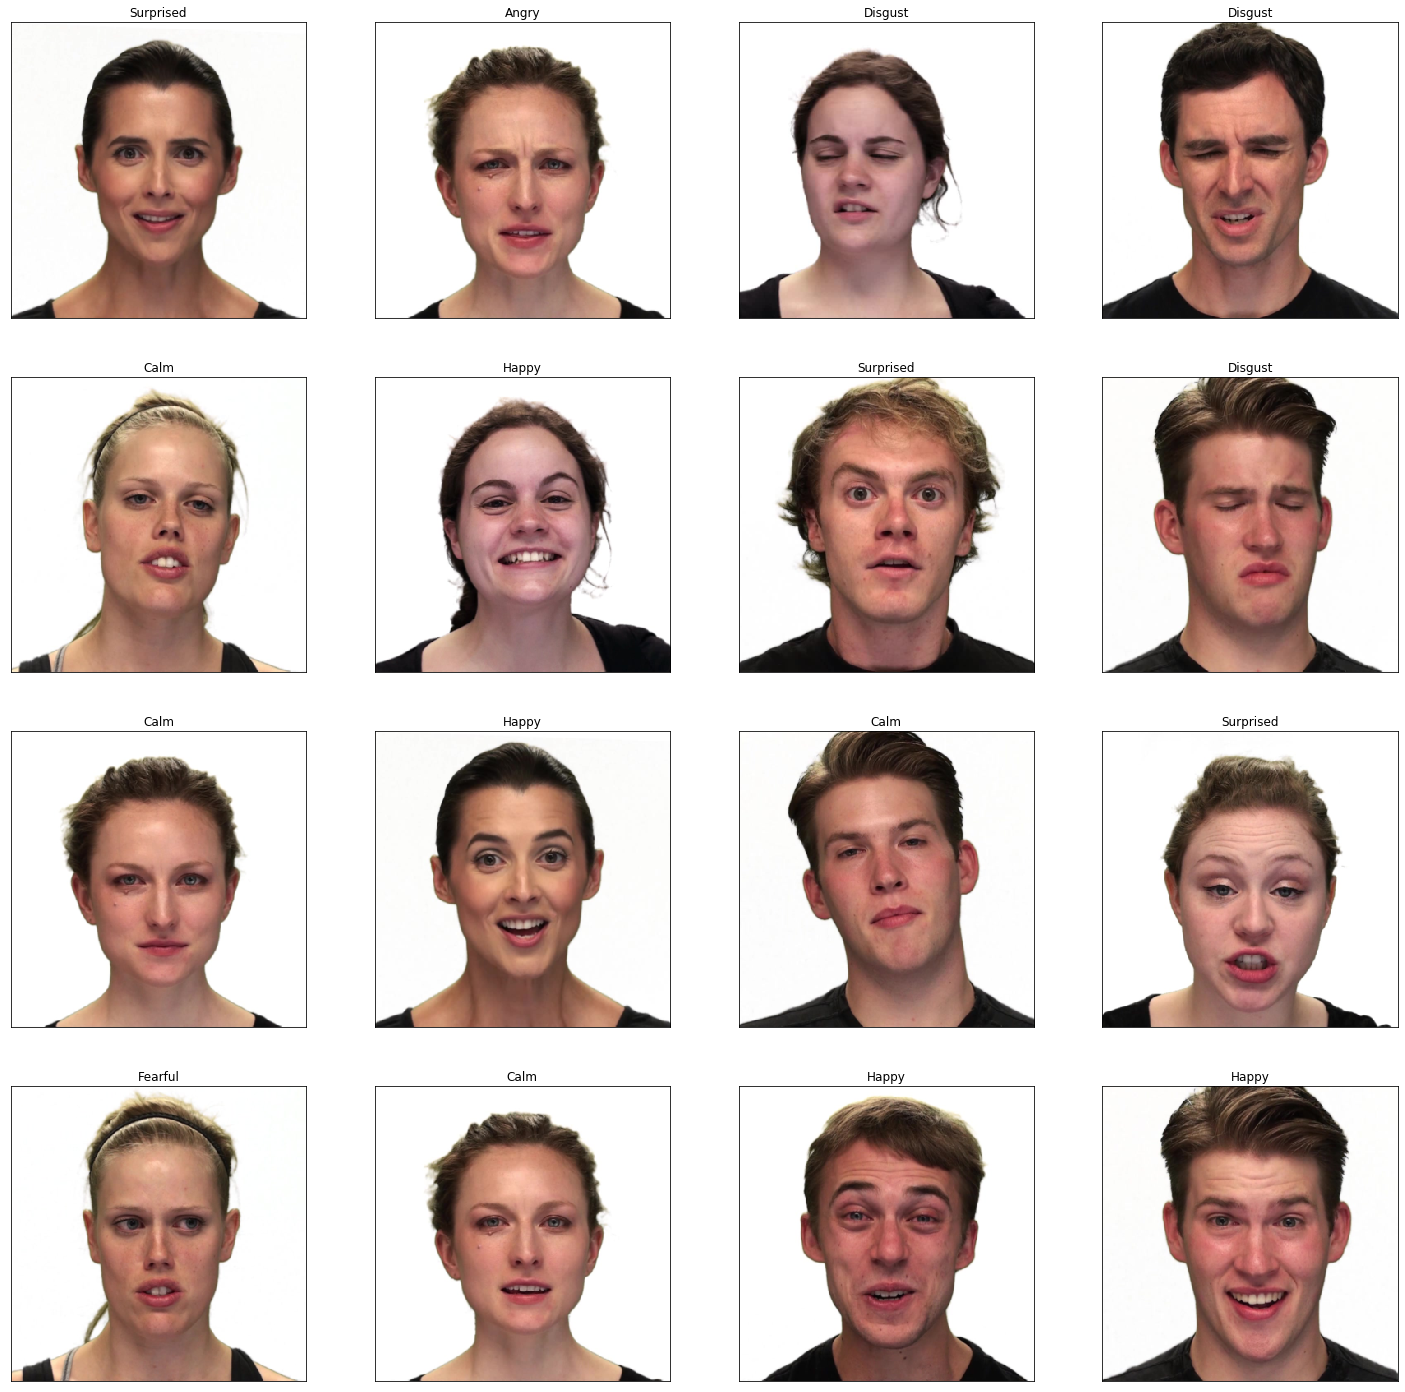

In [80]:
# Verification Step - obtain one batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']

# plot the images in the batch, along with the corresponding labels
height = batch_size/4
fig = plt.figure(figsize=(25, 25))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(height, batch_size/height, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

Surprised
tensor([7, 1, 6, 7, 1, 1, 1, 3, 0, 0, 1, 0, 7, 1, 0, 1, 0, 5, 6, 1, 7, 4, 3, 4,
        1, 6, 5, 3, 3, 6, 1, 2])


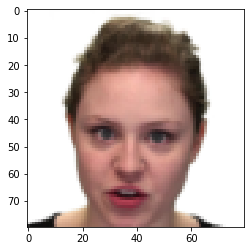

Sad
tensor([6, 6, 5, 0, 7, 6, 2, 7, 6, 4, 3, 0, 0, 7, 0, 2, 1, 6, 0, 0, 3, 6, 7, 2,
        2, 4, 4, 1, 6, 3, 5, 3])


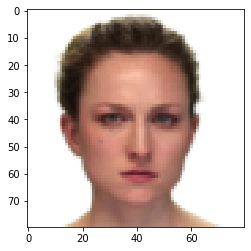

Happy
tensor([4, 7, 3, 7, 6, 7, 7, 4, 1, 4, 0, 6, 2, 4, 3, 2, 7, 1, 0, 1, 1, 1, 0, 1,
        3, 6, 0, 2, 6, 2, 3, 4])


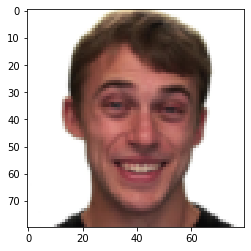

Sad
tensor([6, 2, 3, 2, 0, 3, 1, 2, 6, 6, 1, 1, 0, 1, 3, 7, 1, 0, 0, 1, 1, 1, 6, 7,
        6, 4, 1, 7, 4, 6, 1, 5])


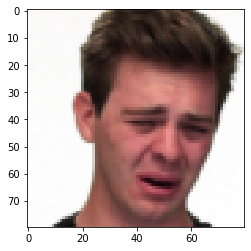

Calm
tensor([1, 3, 1, 7, 3, 1, 4, 5, 6, 4, 7, 0, 1, 6, 6, 0, 1, 4, 3, 2, 0, 3, 7, 6,
        2, 4, 7, 2, 5, 4, 3, 0])


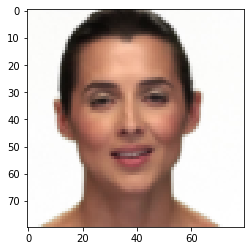

Surprised
tensor([7, 6, 5, 1, 2, 4, 2, 6, 0, 7, 1, 5, 2, 4, 4, 6, 2, 1, 1, 6, 7, 0, 7, 1,
        3, 1, 0, 7, 5, 3, 4, 1])


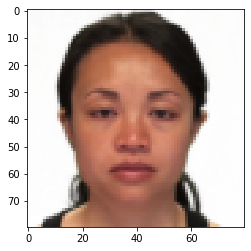

Disguest
tensor([2, 3, 7, 7, 3, 1, 7, 7, 0, 3, 5, 6, 0, 3, 6, 0, 1, 2, 6, 7, 3, 3, 4, 7,
        4, 7, 3, 7, 6, 3, 4, 7])


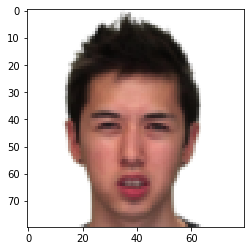

Sad
tensor([6, 2, 3, 0, 7, 6, 1, 0, 2, 4, 1, 6, 7, 4, 0, 4, 6, 2, 0, 4, 0, 0, 3, 0,
        1, 2, 4, 3, 6, 1, 2, 6])


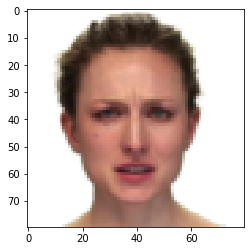

Fearful
tensor([3, 2, 2, 7, 4, 1, 6, 0, 0, 5, 6, 6, 6, 1, 4, 7, 4, 2, 6, 2, 1, 1, 5, 1,
        3, 4, 6, 3, 6, 7, 2, 6])


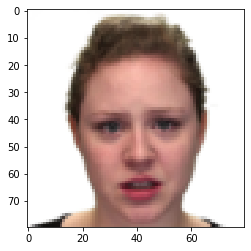

Happy
tensor([4, 0, 3, 3, 6, 6, 0, 1, 6, 5, 5, 7, 6, 4, 1, 2, 2, 2, 1, 0, 4, 1, 3, 0,
        2, 1, 6, 6, 3, 2, 1, 3])


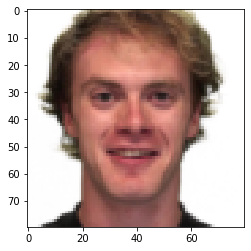

Calm
tensor([1, 1, 2, 1, 4, 7, 1, 6, 3, 3, 4, 1, 7, 3, 4, 6, 1, 4, 2, 1, 0, 7, 0, 7,
        1, 2, 6, 3, 1, 7, 7, 2])


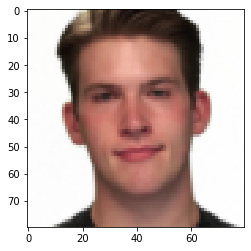

Neutral
tensor([5, 6, 7, 4, 7, 1, 7, 2, 5, 4, 1, 1, 0, 0, 4, 6, 0, 3, 3, 3, 5, 7, 7, 1,
        6, 5, 4, 3, 0, 6, 2, 5])


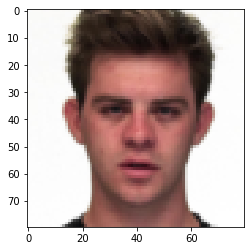

Sad
tensor([6, 3, 4, 6, 6, 0, 2, 0, 4, 6, 4, 1, 6, 5, 4, 0, 2, 3, 3, 3, 7, 6, 3, 7,
        6, 1, 1, 6, 7, 7, 2, 7])


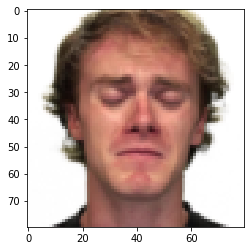

Happy
tensor([4, 1, 4, 2, 0, 4, 4, 3, 6, 1, 0, 2, 1, 2, 3, 6, 3, 4, 1, 6, 1, 2, 3, 7,
        4, 6, 3, 2, 1, 2, 7, 7])


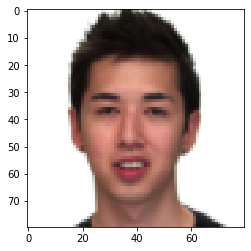

Surprised
tensor([7, 6, 6, 6, 4, 4, 7, 0, 1, 1, 1, 1, 2, 7, 4, 7, 2, 3, 6, 4, 1, 3, 6, 2,
        6, 1, 2, 1, 4, 1, 6, 6])


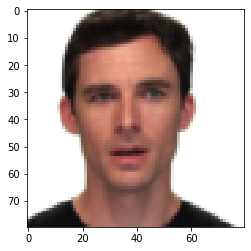

Fearful
tensor([3, 0, 3, 7, 2, 4, 6, 3, 2, 3, 1, 7, 2, 4, 3, 0, 4, 2, 4, 2, 4, 6, 6, 3,
        0, 2, 2, 0, 3, 0, 7, 3])


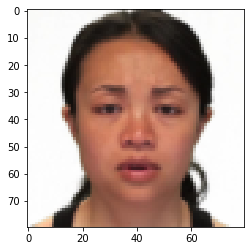

Calm
tensor([1, 3, 2, 0, 1, 6, 2, 4, 2, 3, 3, 0, 6, 7, 0, 3, 3, 1, 3, 3, 4, 3, 1, 1,
        6, 3, 5, 3, 0, 0, 7, 3])


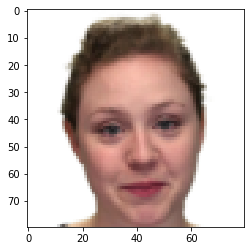

Angery
tensor([0, 3, 1, 5, 2, 4, 2, 0, 0, 2, 3, 3, 4, 1, 7, 0, 2, 1, 1, 3, 0, 6, 4, 0,
        2, 2, 6, 1, 5, 3, 1, 4])


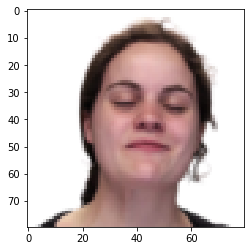

Surprised
tensor([7, 6, 7, 4, 0, 2, 0, 4, 3, 5, 3, 0, 2, 3, 4, 3, 7, 7, 7, 7, 7, 6, 0, 1,
        0, 1, 4, 0, 0, 6, 4, 4])


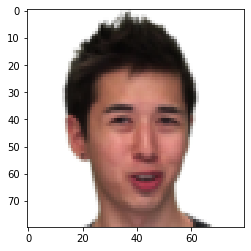

Happy
tensor([4, 0, 0, 6, 3, 6, 0, 2, 6, 4, 7, 5, 0, 0, 4, 4, 7, 1, 1, 7, 6, 4, 1, 7,
        0, 6, 6, 4, 4, 5, 4, 6])


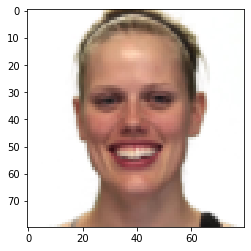

Angery
tensor([0, 2, 7, 7, 6, 4, 3, 1, 1, 6, 4, 0, 5, 7, 0, 2, 0, 1, 0, 6, 4, 0, 3, 7,
        4, 0, 6, 7, 6, 5, 3, 1])


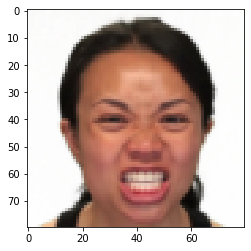

Sad
tensor([6, 7, 2, 5, 1, 4, 7, 3, 5, 7, 6, 1, 0, 7, 2, 1, 0, 0, 1, 6, 1, 4, 2, 0,
        0, 2, 5, 3, 5, 0, 3, 4])


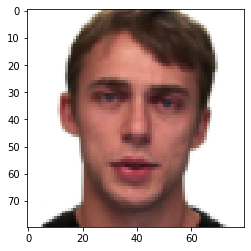

Surprised
tensor([7, 1, 7, 0, 4, 3, 0, 0, 4, 7, 2, 2, 4, 4, 7, 4, 0, 0, 1, 0, 4, 0, 2, 5,
        3, 4, 2, 0, 2, 4, 7, 2])


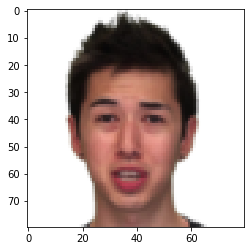

Happy
tensor([4, 3, 2, 7, 7, 0, 2, 4, 3, 1, 7, 3, 0, 7, 4, 6, 4, 1, 4, 1, 3, 6, 7, 0,
        4, 5, 6, 3, 1, 2, 3, 5])


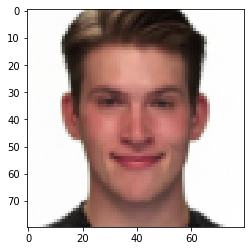

Fearful
tensor([3, 0, 1, 7, 5, 4, 2, 5, 6, 6, 7, 6, 7, 3, 6, 2, 1, 2, 4, 1, 2, 1, 1, 3,
        3, 0, 5, 6, 5, 0, 2, 6])


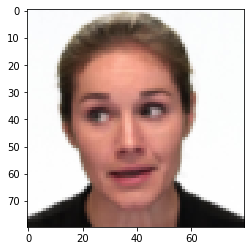

Angery
tensor([0, 4, 5, 4, 7, 0, 3, 7, 0, 2, 4, 6, 2, 4, 5, 1, 7, 0, 5, 7, 7, 0, 6, 5,
        1, 1, 1, 2, 2, 0, 7, 3])


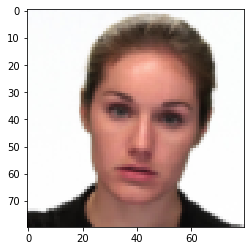

Angery
tensor([0, 0, 3, 1, 2, 3, 2, 0, 1, 0, 0, 4, 5, 2, 4, 2, 4, 1, 3, 0, 3, 0, 1, 7,
        5, 1, 5, 7, 6, 7, 3, 2])


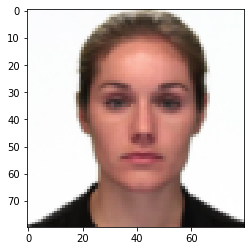

Angery
tensor([0, 4, 3, 0, 6, 5, 6, 3, 0, 0, 1, 2, 3, 0, 0, 3, 2, 6, 4, 6, 1, 5, 6, 1,
        7, 4, 5, 4, 3, 7, 1, 0])


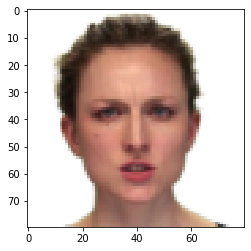

Calm
tensor([1, 4, 3, 7, 1, 1, 0, 4, 4, 7, 1, 2, 6, 1, 2, 3, 5, 5, 6, 1, 4, 5, 5, 1,
        2, 6, 3, 1, 3, 0, 6, 4])


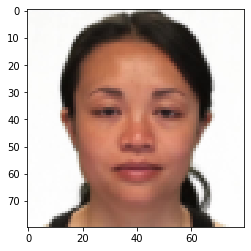

Disguest
tensor([2, 3, 3, 3, 2, 5, 4, 4, 0, 2, 4, 5, 1, 1, 4, 2, 2, 6, 3, 2, 5, 3, 5, 4,
        2, 6, 3, 6, 7, 5, 0, 0])


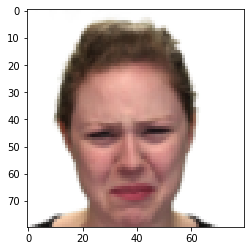

Surprised
tensor([7, 3, 3, 7, 6, 1, 4, 5, 0, 1, 3, 2, 0, 7, 4, 7, 5, 0, 4, 0, 3, 7, 2, 4,
        2, 2, 4, 3, 5, 7, 1, 3])


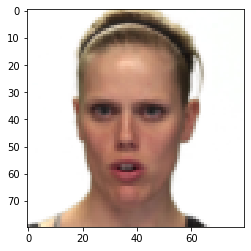

Disguest
tensor([2, 3, 0, 2, 1, 7, 3, 5, 3, 0, 3, 2, 7, 4, 5, 3, 0, 2, 6, 3, 0, 2, 3, 7,
        6, 2, 3, 0, 6, 0, 1, 3])


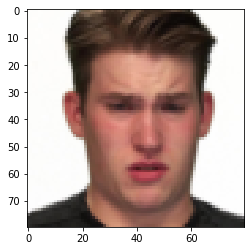

In [7]:
for img, label in small_loader:
    print(classes[label[0]])
    print(label)
    plt.imshow(np.transpose(img[0], (1, 2, 0)))
    plt.show()

## Model

In [47]:
torch.manual_seed(1) # set the random seed

class EmotionNet(nn.Module):
    def __init__(self):
        super(EmotionNet, self).__init__()
        self.name = "EmotionNet"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(10*18*18, 18*18)
        self.fc2 = nn.Linear(18*18, 32)
        self.fc3 = nn.Linear(32, 8)

    def forward(self, img):
        x = self.pool1(F.relu(self.conv1(img)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print("shape", x.shape)
        x = x.view(-1, 10*18*18)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training Code

In [3]:
def normalize_label(labels_raw):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    # convert lable to an array of 8
    labels = np.zeros((len(labels_raw), 8))
    labels[range(len(labels_raw)), labels_raw] = 1
    return torch.tensor(labels)

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    if len(loader) == 0:
       return (0, 0)
    total_loss = 0.0
    total_acc = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels_raw = data
        labels = normalize_label(labels_raw)
        
        if torch.cuda.is_available():
          inputs = inputs.cuda()
          labels_raw = labels_raw.cuda()
          labels = labels.cuda()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        correct = outputs.argmax(1) == labels_raw
        
        total_acc += int(correct.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
        
    acc = float(total_acc) / total_epoch
    loss = float(total_loss) / (i + 1)
    return acc, loss

def get_accuracy(model, data_loader, criterion):
    if(len(data_loader) == 0):
        return 0,0
    
    correct = 0
    total = 0
    total_loss = 0.0
    print("len data_loader", len(data_loader))
    i=0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        loss = criterion(output, labels)
        
        print("output:", output)
        print("labels:", labels)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
                
        total_loss += float(loss)
        print("idx:", i)
        i+=1
        print("loss.item():", total_loss)
        print("labels:", labels.shape)
        
    return (correct/total, total_loss/(len(data_loader)))

def train_net(net, train_loader, val_loader, batch_size=32, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    print("Use Cuda:", torch.cuda.is_available())
    print("Train loader size:", len(train_loader))
    print("Val loader size:", len(val_loader))
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Set the net to use Cuda if it is available
    if torch.cuda.is_available():
        net.cuda()
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    # print("Starting to learn")
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels_raw = data
            labels = normalize_label(labels_raw)

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels_raw = labels_raw.cuda()
                labels = labels.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_err[epoch], train_loss[epoch] = evaluate(net, train_loader, criterion)
        # print("starting validation")
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train acc: {:.3f}, Train loss: {:.3f} |"+
               "Val acc: {:.3f}, Val loss: {:.3f}| time: {:.2f}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch],
                   time.time()-start_time))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch+1)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    plot_training_curve(model_path)

## Overfitting to small subset

Use Cuda: True
Train loader size: 32
Val loader size: 0
Epoch 1: Train acc: 0.125, Train loss: 0.539 |Val acc: 0.000, Val loss: 0.000| time: 0.94
Epoch 2: Train acc: 0.156, Train loss: 0.381 |Val acc: 0.000, Val loss: 0.000| time: 1.93
Epoch 3: Train acc: 0.188, Train loss: 0.385 |Val acc: 0.000, Val loss: 0.000| time: 2.91
Epoch 4: Train acc: 0.219, Train loss: 0.375 |Val acc: 0.000, Val loss: 0.000| time: 3.89
Epoch 5: Train acc: 0.219, Train loss: 0.364 |Val acc: 0.000, Val loss: 0.000| time: 4.88
Epoch 6: Train acc: 0.219, Train loss: 0.375 |Val acc: 0.000, Val loss: 0.000| time: 5.85
Epoch 7: Train acc: 0.219, Train loss: 0.360 |Val acc: 0.000, Val loss: 0.000| time: 6.81
Epoch 8: Train acc: 0.219, Train loss: 0.360 |Val acc: 0.000, Val loss: 0.000| time: 7.79
Epoch 9: Train acc: 0.188, Train loss: 0.363 |Val acc: 0.000, Val loss: 0.000| time: 8.76
Epoch 10: Train acc: 0.219, Train loss: 0.359 |Val acc: 0.000, Val loss: 0.000| time: 9.72
Epoch 11: Train acc: 0.219, Train loss: 0.3

Epoch 90: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 88.07
Epoch 91: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 89.09
Epoch 92: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 90.05
Epoch 93: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 91.03
Epoch 94: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 91.99
Epoch 95: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 92.95
Epoch 96: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 93.92
Epoch 97: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 94.90
Epoch 98: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 95.87
Epoch 99: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 96.83
Epoch 100: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000|

Epoch 178: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 177.06
Epoch 179: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 178.04
Epoch 180: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 179.03
Epoch 181: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 180.00
Epoch 182: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 180.96
Epoch 183: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 181.92
Epoch 184: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 182.89
Epoch 185: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 183.88
Epoch 186: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 184.84
Epoch 187: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.000, Val loss: 0.000| time: 185.80
Epoch 188: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.0

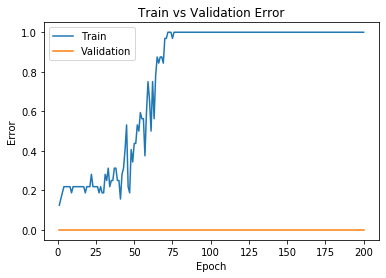

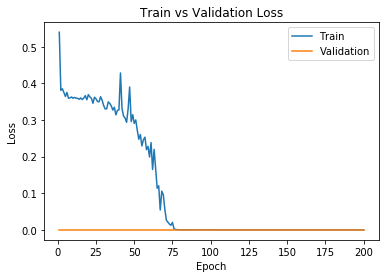

In [143]:
"""
Overfitted data use the new BCEWithLogitsLoss, and SGD formulas.
"""
net = EmotionNet()
if torch.cuda.is_available():
  net.cuda()

train_net(net, small_loader, [], num_epochs=200, learning_rate=0.01, batch_size=batch_size)

## Training the Model

Use Cuda: True
Train loader size: 164
Val loader size: 59
Epoch 1: Train acc: 0.139, Train loss: 0.374 |Val acc: 0.135, Val loss: 0.374| time: 132.74
Epoch 2: Train acc: 0.175, Train loss: 0.374 |Val acc: 0.191, Val loss: 0.374| time: 265.48
Epoch 3: Train acc: 0.142, Train loss: 0.372 |Val acc: 0.146, Val loss: 0.373| time: 398.60
Epoch 4: Train acc: 0.197, Train loss: 0.368 |Val acc: 0.166, Val loss: 0.370| time: 528.10
Epoch 5: Train acc: 0.228, Train loss: 0.359 |Val acc: 0.202, Val loss: 0.367| time: 652.62
Epoch 6: Train acc: 0.205, Train loss: 0.363 |Val acc: 0.168, Val loss: 0.377| time: 773.71
Epoch 7: Train acc: 0.232, Train loss: 0.352 |Val acc: 0.189, Val loss: 0.370| time: 895.14
Epoch 8: Train acc: 0.226, Train loss: 0.349 |Val acc: 0.182, Val loss: 0.371| time: 1017.61
Epoch 9: Train acc: 0.258, Train loss: 0.346 |Val acc: 0.195, Val loss: 0.376| time: 1139.04
Epoch 10: Train acc: 0.262, Train loss: 0.346 |Val acc: 0.202, Val loss: 0.377| time: 1259.51
Epoch 11: Train ac

Epoch 88: Train acc: 0.999, Train loss: 0.002 |Val acc: 0.292, Val loss: 1.961| time: 10785.76
Epoch 89: Train acc: 0.998, Train loss: 0.002 |Val acc: 0.301, Val loss: 2.116| time: 10900.29
Epoch 90: Train acc: 0.999, Train loss: 0.002 |Val acc: 0.307, Val loss: 1.959| time: 11014.90
Epoch 91: Train acc: 1.000, Train loss: 0.001 |Val acc: 0.304, Val loss: 2.149| time: 11129.57
Epoch 92: Train acc: 0.993, Train loss: 0.007 |Val acc: 0.304, Val loss: 2.086| time: 11244.20
Epoch 93: Train acc: 0.999, Train loss: 0.003 |Val acc: 0.292, Val loss: 1.926| time: 11358.70
Epoch 94: Train acc: 0.999, Train loss: 0.002 |Val acc: 0.296, Val loss: 2.229| time: 11473.36
Epoch 95: Train acc: 1.000, Train loss: 0.001 |Val acc: 0.295, Val loss: 2.250| time: 11587.81
Epoch 96: Train acc: 0.999, Train loss: 0.002 |Val acc: 0.293, Val loss: 2.121| time: 11702.36
Epoch 97: Train acc: 0.998, Train loss: 0.003 |Val acc: 0.286, Val loss: 2.124| time: 11816.95
Epoch 98: Train acc: 1.000, Train loss: 0.001 |Val

Epoch 174: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.297, Val loss: 3.034| time: 20643.60
Epoch 175: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.296, Val loss: 3.061| time: 20758.32
Epoch 176: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.297, Val loss: 3.057| time: 20872.88
Epoch 177: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.296, Val loss: 3.036| time: 20987.58
Epoch 178: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.295, Val loss: 3.053| time: 21102.16
Epoch 179: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.296, Val loss: 3.037| time: 21216.72
Epoch 180: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.296, Val loss: 3.035| time: 21331.42
Epoch 181: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.296, Val loss: 3.071| time: 21446.03
Epoch 182: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.297, Val loss: 3.060| time: 21560.62
Epoch 183: Train acc: 1.000, Train loss: 0.000 |Val acc: 0.297, Val loss: 3.067| time: 21675.24
Epoch 184: Train acc: 1.000, Train loss:

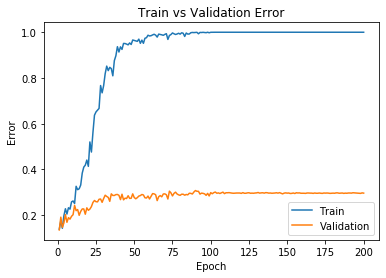

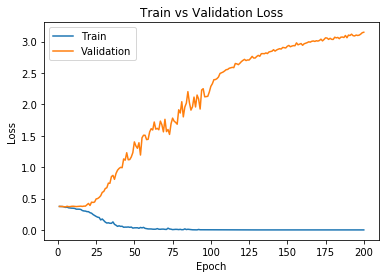

In [48]:
"""
Overfitted data use the new BCEWithLogitsLoss, and SGD formulas.
"""
net = EmotionNet()
train_net(net, train_loader, val_loader, num_epochs=200, learning_rate=0.01, batch_size=batch_size)

## Train model with the Alex feature set

### Save the Alex features to a file

In [29]:
# Save Features to Folder (assumes code from 1. has been evaluated)

import os
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

# location on Google Drive
master_path = 'alex-features'

classes = ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']

# save features to folder as tensors
start = time.time();
for name, loader in [("train", train_loader), ("val", val_loader), ("test", test_loader)]:
    print(name)
    n = 0
    for img, label in loader:
        features = alexnet.features(img)
        features_tensor = torch.from_numpy(features.detach().numpy())

        folder_name = master_path + '/' + name + '/' + str(classes[label])
        if not os.path.isdir(folder_name):
            os.mkdir(folder_name)
        torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
        n += 1
    print(time.time()-start)

train
132.56438159942627
val
180.4657380580902
test
226.27710556983948


### Load the Alex features from a file

In [4]:
# Load Tensor Files (features) from folder

#load features
# location on Google Drive
master_path = 'alex-features'
train_set = torchvision.datasets.DatasetFolder(master_path+'/train', loader=torch.load, extensions=('.tensor'))
val_set = torchvision.datasets.DatasetFolder(master_path+'/val', loader=torch.load, extensions=('.tensor'))
test_set = torchvision.datasets.DatasetFolder(master_path+'/test', loader=torch.load, extensions=('.tensor'))

# Prepare Dataloader
batch_size = 32
num_workers = 1
train_f_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_f_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_f_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
print("Train")
dataiter = iter(train_f_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)
print(len(train_f_loader))

print("Val")
dataiter = iter(val_f_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)
print(len(val_f_loader))

print("Test")
dataiter = iter(test_f_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)
print(len(test_f_loader))

Train
torch.Size([32, 256, 10, 10])
torch.Size([32])
164
Val
torch.Size([32, 256, 10, 10])
torch.Size([32])
59
Test
torch.Size([32, 256, 10, 10])
torch.Size([32])
56


## Alex Net Model

1. 3 layer (256,192,128,8) lr 0.005, bs 32, e 75.

1. 3 layer (256,192,128,8) lr 0.01, bs 32, e 175. Max val acc of 29.4% @ e51.

1. Increase the resolution of the images from 160x90 to 640x360. 3 layer (256,192,128,8) lr 0.01, bs 32, e 175. Max val acc of 47.0% @ e15.

1. Increase the resolution of the images from 640x360 to 1280x720. 3 layer (256,192,128,8) lr 0.01, bs 32, e 30. Max val acc of 43.7% @ e9.

1. 3 layer lr 0.005, bs 32, e 30. Max val acc of 42% @ e23.

1. Decreased the image size back down to 640x360. 3 layer (256,192,128,8) lr 0.005, bs 32, e30. Max val acc of 47.2% @ e15.

1. 3 layer, lr 0.0001, bs 32, e45. Max val acc of 35% @ e45 (need more epochs, so increase the lr a little)

1. 3 layer, lr 0.0005, bs 32, e45. Max val acc of 42.2% @ e23.

1. 3 layer, lr 0.001, bs 32, e75. Max val acc of 47.7% @ e68. ---------best-------------

1. 3 layer, lr 0.001, bs 16, e75. Max val acc of 47.2% @ e28.

1. 3 layer, lr 0.001, bs 64, e75. Max val acc of 43%.

1. Copied and pasted the neutral data because there is only half as much data. Duplicated the nutral set. 3 layer, lr 0.001, bs 32, e80. 

1. Final run: 3 layer, lr 0.001, bs 32, e75. Max val acc of 47.7% @ e68. ---------best-------------

In [5]:
torch.manual_seed(1) # set the random seed

class AlexASLNet(nn.Module):
    def __init__(self):
        super(AlexASLNet, self).__init__()
        self.name = "AlexEmotionNet-3layer-640-final"
        self.fc1 = nn.Linear(256*10*10, 192)
        self.fc2 = nn.Linear(192, 128)
        self.fc3 = nn.Linear(128, 8)

    def forward(self, img):
        x = img.view(-1, 256*10*10)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train Alex Net Model

Use Cuda: True
Train loader size: 164
Val loader size: 59
Epoch 1: Train acc: 0.252, Train loss: 0.367 |Val acc: 0.198, Val loss: 0.370| time: 2.90
Epoch 2: Train acc: 0.334, Train loss: 0.358 |Val acc: 0.302, Val loss: 0.363| time: 5.82
Epoch 3: Train acc: 0.387, Train loss: 0.345 |Val acc: 0.304, Val loss: 0.355| time: 8.70
Epoch 4: Train acc: 0.442, Train loss: 0.329 |Val acc: 0.314, Val loss: 0.345| time: 11.92
Epoch 5: Train acc: 0.479, Train loss: 0.315 |Val acc: 0.336, Val loss: 0.337| time: 14.90
Epoch 6: Train acc: 0.539, Train loss: 0.300 |Val acc: 0.351, Val loss: 0.329| time: 17.83
Epoch 7: Train acc: 0.574, Train loss: 0.286 |Val acc: 0.373, Val loss: 0.322| time: 20.72
Epoch 8: Train acc: 0.566, Train loss: 0.273 |Val acc: 0.387, Val loss: 0.319| time: 23.63
Epoch 9: Train acc: 0.621, Train loss: 0.257 |Val acc: 0.405, Val loss: 0.315| time: 26.54
Epoch 10: Train acc: 0.662, Train loss: 0.244 |Val acc: 0.406, Val loss: 0.312| time: 29.45
Epoch 11: Train acc: 0.671, Train 

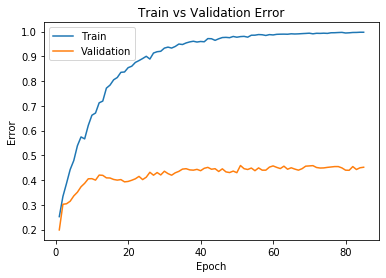

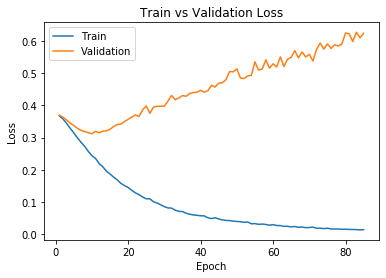

In [32]:
net = AlexASLNet()
train_net(net, train_f_loader, val_f_loader, num_epochs=85, learning_rate=0.001, batch_size=batch_size)

In [6]:
"""
Final Model
"""
net = AlexASLNet()
if torch.cuda.is_available():
    net = net.cuda()
net.load_state_dict(torch.load("models/3-fullset-alex-640-img/model_AlexEmotionNet-3layer-640_bs32_lr0.001_epoch12"))
print("Train acc:", evaluate(net, train_f_loader, nn.BCEWithLogitsLoss()))
print("Val acc:", evaluate(net, val_f_loader, nn.BCEWithLogitsLoss()))
print("Test acc:", evaluate(net, test_f_loader, nn.BCEWithLogitsLoss()))

Train acc: (0.7087081339712918, 0.22139415516579264)
Val acc: (0.41630901287553645, 0.31514112057639027)
Test acc: (0.31046119235095615, 0.3593403281421176)


## Confusion matrix

In [55]:
def confusion_matrix(net, loader):
    classes = ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised', 'Total']
    matrix = np.zeros((9, 9))
    
    for imgs, labels in loader:
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        output = net(imgs).argmax(dim=1)
        
        for i in range(len(labels)):
            matrix[labels[i], output[i]] += 1
    
    matrix[8, :] = matrix.sum(axis=0)
    matrix[:, 8] = matrix.sum(axis=1)
    
    return pd.DataFrame(data=matrix, index=classes, columns=classes) # index is the label, columns is the output

In [52]:
print("Train data")
confusion_matrix(net, train_f_loader)

Train data


,Angry,Calm,Disgust,Fearful,Happy,Neutral,Sad,Surprised,Total
Angry,531.0,15.0,36.0,104.0,8.0,3.0,35.0,2.0,734.0
Calm,4.0,635.0,7.0,13.0,44.0,1.0,12.0,4.0,720.0
Disgust,17.0,3.0,661.0,38.0,4.0,0.0,20.0,1.0,744.0
Fearful,92.0,5.0,22.0,537.0,11.0,1.0,5.0,3.0,676.0
Happy,5.0,84.0,12.0,11.0,563.0,0.0,10.0,2.0,687.0
Neutral,0.0,116.0,3.0,29.0,1.0,146.0,32.0,3.0,330.0
Sad,52.0,17.0,80.0,71.0,28.0,3.0,435.0,1.0,687.0
Surprised,104.0,32.0,46.0,173.0,39.0,13.0,45.0,195.0,647.0
Total,805.0,907.0,867.0,976.0,698.0,167.0,594.0,211.0,5225.0


In [53]:
print("Val data")
confusion_matrix(net, val_f_loader)

Val data


,Angry,Calm,Disgust,Fearful,Happy,Neutral,Sad,Surprised,Total
Angry,153.0,3.0,30.0,51.0,6.0,2.0,13.0,0.0,258.0
Calm,14.0,163.0,4.0,16.0,37.0,0.0,16.0,1.0,251.0
Disgust,34.0,3.0,148.0,47.0,2.0,0.0,39.0,0.0,273.0
Fearful,68.0,6.0,23.0,110.0,15.0,1.0,15.0,1.0,239.0
Happy,5.0,25.0,7.0,25.0,169.0,0.0,11.0,1.0,243.0
Neutral,23.0,56.0,0.0,16.0,2.0,4.0,9.0,3.0,113.0
Sad,76.0,9.0,104.0,33.0,1.0,1.0,24.0,0.0,248.0
Surprised,42.0,18.0,52.0,74.0,5.0,11.0,32.0,5.0,239.0
Total,415.0,283.0,368.0,372.0,237.0,19.0,159.0,11.0,1864.0


In [54]:
print("Test data")
confusion_matrix(net, test_f_loader)

Test data


,Angry,Calm,Disgust,Fearful,Happy,Neutral,Sad,Surprised,Total
Angry,65.0,16.0,11.0,136.0,1.0,7.0,8.0,0.0,244.0
Calm,39.0,111.0,4.0,66.0,6.0,5.0,14.0,0.0,245.0
Disgust,43.0,19.0,129.0,38.0,6.0,3.0,5.0,0.0,243.0
Fearful,58.0,16.0,17.0,122.0,3.0,7.0,4.0,0.0,227.0
Happy,37.0,54.0,5.0,46.0,83.0,0.0,5.0,0.0,230.0
Neutral,24.0,43.0,3.0,27.0,1.0,18.0,0.0,0.0,116.0
Sad,67.0,34.0,34.0,64.0,0.0,18.0,23.0,1.0,241.0
Surprised,48.0,46.0,19.0,78.0,9.0,28.0,3.0,1.0,232.0
Total,381.0,339.0,222.0,577.0,109.0,86.0,62.0,2.0,1778.0
